# Forecasting Sales for 45 Walmart Locations

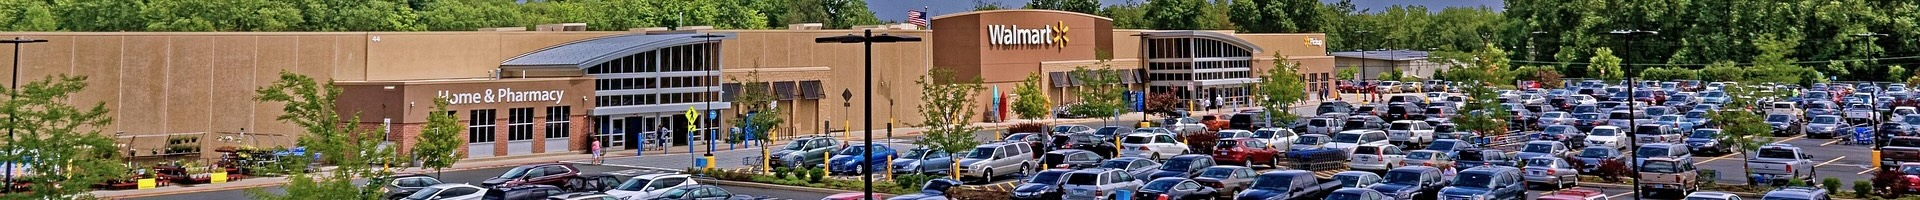
Image by <a href="https://pixabay.com/users/jimarojfm-8012735/?utm_source=link-attribution&utm_medium=referral&utm_campaign=image&utm_content=4054031">jimaro morales</a> from <a href="https://pixabay.com//?utm_source=link-attribution&utm_medium=referral&utm_campaign=image&utm_content=4054031">Pixabay</a>

### **Table of Contents**
* [<span style="color:#A690A4"> 0. Executive Summary](#exe_sum)
* [<span style="color:#A690A4"> 1. Introduction](#intro)
* [<span style="color:#A690A4"> 2. Collect & Clean Data](#collect)
* [<span style="color:#A690A4"> 3. Wrangle & Explore Data](#process)
* [<span style="color:#A690A4"> 4. Forecast Sales](#predict)
* [<span style="color:#A690A4"> 5. Conclusion](#conclusion)

# <span style="color:#5E6997">Executive Summary</span> <a class="anchor" id="exe_sum"></a>

# <span style="color:#5E6997">Introduction</span> <a class="anchor" id="intro"></a>

# <span style="color:#5E6997">Collect & Clean Data</span> <a class="anchor" id="collect"></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Define file paths
# features_path = "/kaggle/input/walmart-sales-forecast/features.csv"
# stores_path   = "/kaggle/input/walmart-sales-forecast/stores.csv"
# train_path    = "/kaggle/input/walmart-sales-forecast/train.csv"
# test_path     = "/kaggle/input/walmart-sales-forecast/test.csv"

features_path = "./data/features.csv"
stores_path   = "./data/stores.csv"
train_path    = "./data/train.csv"
test_path     = "./data/test.csv"

# Load datasets
features = pd.read_csv(features_path)
stores   = pd.read_csv(stores_path)
train    = pd.read_csv(train_path)
test     = pd.read_csv(test_path)

In [ ]:
# Convert the 'Date' column to datetime format
features["Date"] = pd.to_datetime(features["Date"], format="%Y-%m-%d")
train["Date"] = pd.to_datetime(train["Date"], format="%Y-%m-%d")
test["Date"] = pd.to_datetime(test["Date"], format="%Y-%m-%d")

In [ ]:
# Get min and max dates for train
train_min = train['Date'].min()
train_max = train['Date'].max()

# Get min and max dates for test
test_min = test['Date'].min()
test_max = test['Date'].max()

# Print the date range for the train dataset with day of the week
print("Train Date Range:")
print("Min Date:", train_min, "-", train_min.day_name())
print("Max Date:", train_max, "-", train_max.day_name())

# Print the date range for the test dataset with day of the week
print("\nTest Date Range:")
print("Min Date:", test_min, "-", test_min.day_name())
print("Max Date:", test_max, "-", test_max.day_name())

### Store Data

In [ ]:
stores.tail()

In [ ]:
stores.info()

In [ ]:
def display_feature_range(df):
    """
    Display the range of values for each column in a DataFrame.
    For numeric (non-boolean) columns, prints the minimum, maximum, and range.
    For non-numeric or boolean columns, prints the unique values.
    """
    for col in df.columns:
        print("=" * 40)
        print(f"Feature: {col}")
        
        # Check for numeric columns excluding booleans
        if pd.api.types.is_numeric_dtype(df[col]) and not pd.api.types.is_bool_dtype(df[col]):
            col_min = df[col].min()
            col_max = df[col].max()
            print(f"Min: {col_min}")
            print(f"Max: {col_max}")
            print(f"Range: {col_max - col_min}")
        else:
            unique_vals = df[col].unique()
            print("Unique values:", unique_vals)
        print("=" * 40, "\n")

In [ ]:
# Call the function with the stores dataset
display_feature_range(stores)

### Features Data

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [ ]:
features.head()

In [ ]:
features.tail()

In [ ]:
features.info()

In [ ]:
# Define the list of MarkDown columns
markdown_cols = ["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"]

# Fill missing values in the MarkDown columns with 0
features[markdown_cols] = features[markdown_cols].fillna(0)

# Display info to verify that missing values have been filled
features.info()

In [ ]:
# Create boolean masks where True indicates a missing value
mask_cpi = features['CPI'].isna()
mask_unemployment = features['Unemployment'].isna()

# Check if both masks are exactly the same
if mask_cpi.equals(mask_unemployment):
    print("CPI and Unemployment have the exact same missing value pattern.")
else:
    print("CPI and Unemployment have different missing value patterns.")

In [ ]:
# Rows where CPI  is missing
missing_mask = features['CPI'].isna() 
missing_rows = features[missing_mask]
print(missing_rows)

In [ ]:
# Focus on Store 1 (or whichever store is plotted)
store1 = features[features['Store'] == 1].copy()
store1 = store1.sort_values('Date')

# Inspect data for the time frame around the suspicious jump
suspicious_range = store1[(store1['Date'] >= "2013-04-01") & (store1['Date'] <= "2013-08-31")]
print(suspicious_range[['Date', 'CPI']])

In [ ]:
print(features[['Date', 'Store', 'CPI', 'Unemployment']].tail(30))

In [ ]:
# Set Date as the index for interpolation
features.set_index("Date", inplace=True)

# Step 1: Apply Forward-Fill and Backward-Fill at the Global Level
features[['CPI', 'Unemployment']] = features[['CPI', 'Unemployment']].ffill().bfill()

# Step 2: Apply Linear Interpolation Per Store
features = (
    features.groupby("Store", group_keys=False)  # Ensure per-store interpolation
            .apply(lambda g: g.interpolate(method='linear', limit_direction='both'))  
)

# Reset index so Date becomes a column again
features.reset_index(inplace=True)

In [ ]:
print(features[['Date', 'CPI', 'Unemployment']].tail(30))

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Ensure Date is in datetime format
features['Date'] = pd.to_datetime(features['Date'])

# 2. Sort by Store and Date (only needed once)
features.sort_values(["Store", "Date"], inplace=True)

# 3. Apply Linear Interpolation Per Store (Fix: Use "Date" as the index)
features = (
    features.groupby("Store", group_keys=False)  # Group by store
            .apply(lambda g: g.set_index("Date").interpolate(method='linear', limit_direction='both').reset_index())  
)

# 4. Aggregate to get daily averages across all stores (ensuring one row per date)
daily_avg = features.groupby('Date', as_index=False).agg({
    'CPI': 'mean',
    'Unemployment': 'mean'
})
daily_avg.sort_values('Date', inplace=True)

# 5. Create a dual-axis plot
fig, ax1 = plt.subplots(figsize=(12,6))

# CPI on primary y-axis
color_cpi = 'tab:blue'
ax1.set_xlabel("Date")
ax1.set_ylabel("CPI", color=color_cpi)
ax1.plot(daily_avg['Date'], daily_avg['CPI'], color=color_cpi, label='Avg CPI')
ax1.tick_params(axis='y', labelcolor=color_cpi)

# Unemployment on secondary y-axis
ax2 = ax1.twinx()
color_unemp = 'tab:red'
ax2.set_ylabel("Unemployment", color=color_unemp)
ax2.plot(daily_avg['Date'], daily_avg['Unemployment'], color=color_unemp, label='Avg Unemployment')
ax2.tick_params(axis='y', labelcolor=color_unemp)

plt.title("Average CPI and Unemployment Over Time (All Stores)")
fig.tight_layout()
plt.savefig("CPI_Unemployment_all_stores.jpg", format="jpg", dpi=300)
plt.show()


In [ ]:

# Assuming 'features' is your DataFrame with interpolated CPI and Unemployment

# Choose the store you want to visualize (e.g., Store 1)
store_id = 1
store_df = features[features['Store'] == store_id].copy()

# Sort by Date to ensure the time series is in order
store_df.sort_values('Date', inplace=True)

# Create a dual-axis plot
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot CPI on the primary y-axis
color_cpi = 'tab:blue'
ax1.set_xlabel("Date")
ax1.set_ylabel("CPI", color=color_cpi)
ax1.plot(store_df['Date'], store_df['CPI'], color=color_cpi, label='CPI')
ax1.tick_params(axis='y', labelcolor=color_cpi)

# Create a second y-axis for Unemployment
ax2 = ax1.twinx()
color_unemp = 'tab:red'
ax2.set_ylabel("Unemployment", color=color_unemp)
ax2.plot(store_df['Date'], store_df['Unemployment'], color=color_unemp, label='Unemployment')
ax2.tick_params(axis='y', labelcolor=color_unemp)

plt.title(f"Store {store_id} - CPI and Unemployment Over Time")
fig.tight_layout()
plt.savefig(f"Store_{store_id}_CPI_Unemployment_store_1.jpg", format="jpg", dpi=300)
plt.show()


In [ ]:
# Focus on a time range around the jump
check_range = daily_avg[(daily_avg['Date'] >= "2013-05-01") & (daily_avg['Date'] <= "2013-08-01")]
print(check_range)

In [ ]:
print(daily_avg[['CPI', 'Unemployment']].describe())

In [ ]:
# Check CPI and Unemployment for a wider range to see available data points
check_surrounding = daily_avg[(daily_avg['Date'] >= "2013-01-01") & (daily_avg['Date'] <= "2013-12-01")]
print(check_surrounding)

In [ ]:
print(features[['Date', 'CPI', 'Unemployment']].sort_values('Date').head(20))  # Inspect the first 20 rows
print(features[['Date', 'CPI', 'Unemployment']].sort_values('Date').tail(20))  # Inspect the last 20 rows

In [ ]:
display_feature_range(features)

### Train/Test Data

In [ ]:
train.head()

In [ ]:
train.tail()

In [ ]:
train.info()

In [ ]:
test.info()

In [ ]:
display_feature_range(train)

# <span style="color:#5E6997">Wrangle & Explore Data</span> <a class="anchor" id="process"></a>

In [ ]:
# Merge the 'store' information into 'features'
train = train.merge(stores, on="Store", how="left")

In [ ]:
# Merge 'train' with 'features' on Store and Date
train = train.merge(features, on=["Store", "Date"], how="left")

Calculate Sales per Sqaure Foot.

In [ ]:
train_efficiency = train.groupby('Store', as_index=False)['Weekly_Sales'].sum()
train_efficiency = train_efficiency.merge(stores[['Store', 'Size']], on='Store')
train['Sales_per_sqft'] = train_efficiency['Weekly_Sales'] / train_efficiency['Size']


In [ ]:
stores.head()

In [ ]:
train.columns

In [ ]:
# Rename 'IsHoliday_y' to 'Holiday'
train.rename(columns={'IsHoliday_y': 'Holiday'}, inplace=True)

# Drop 'IsHoliday_x' 
train.drop(columns=['IsHoliday_x'], inplace=True, errors='ignore')

In [ ]:
train.head()

### Sales Trends Over Time

Goal: Identify seasonal trends, holiday effects, and overall sales growth.

In [ ]:

# Aggregate total weekly sales per Date
weekly_sales = train.groupby('Date', as_index=False)['Weekly_Sales'].sum()

# Plot total sales over time
plt.figure(figsize=(12,6))
plt.plot(weekly_sales['Date'], weekly_sales['Weekly_Sales'], label='Total Weekly Sales', color='tab:blue', alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Total Weekly Sales")
plt.title("Walmart Weekly Sales Trend Over Time")
plt.legend()
plt.grid(True)
plt.savefig("Sales_Trends_Over_Time.jpg", format="jpg", dpi=300)
plt.show()


Graph observations:

1. **Seasonal Peaks** – There are **sharp spikes** in sales, particularly around the **end of each year**. This suggests that major shopping events, such as **Black Friday and holiday sales**, significantly impact sales figures.
2. **General Fluctuations** – While sales remain relatively stable throughout the time period, **there are noticeable fluctuations** that might correspond to promotional periods, economic conditions, or external factors affecting consumer spending.
3. **Downward Trends** – The beginning of the dataset (2010) shows relatively **higher variance**, with some downward trends visible over time. This could indicate changes in store performance, economic conditions, or shifts in consumer behavior.
4. **Post-Holiday Declines** – After each peak, sales **drop sharply**, suggesting that consumers **spend significantly more during peak shopping seasons** and cut back afterward.

### Total Sales by Store

Goal: Find which stores generate the most revenue and spot outliers.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Aggregate total sales per store
store_sales = train.groupby('Store')['Weekly_Sales'].sum().sort_values().reset_index()

# Step 2: Merge with store metadata to get 'Type'
store_metadata = stores[['Store', 'Type']]  # assuming your store info is in a DataFrame called 'stores'
store_sales = store_sales.merge(store_metadata, on='Store')

# Step 3: Assign colors to each type
type_colors = {'A': 'skyblue', 'B': 'orange', 'C': 'green'}
store_sales['Color'] = store_sales['Type'].map(type_colors)

# Step 4: Plot
plt.figure(figsize=(12,6))
plt.bar(store_sales['Store'].astype(str), store_sales['Weekly_Sales'], color=store_sales['Color'], alpha=0.8)

# Step 5: Formatting
plt.xlabel("Store Number")
plt.ylabel("Total Sales")
plt.title("Total Sales by Store (Color-Coded by Store Type)")
plt.xticks(rotation=90)
plt.grid(axis='y')

# Step 6: Custom Legend
handles = [plt.Rectangle((0,0),1,1, color=col) for col in type_colors.values()]
labels = [f"Type {t}" for t in type_colors.keys()]
plt.legend(handles, labels, title="Store Type")

# Step 7: Save and Show
plt.tight_layout()
plt.savefig("Sales_By_Store_Type_Overlay.jpg", format="jpg", dpi=300)
plt.show()

1. **Wide Range of Sales Performance**  
   - There is a **significant disparity** in total sales between stores.  
   - The lowest-performing stores have total sales below **$50,000,000**, whereas the highest-performing stores exceed **$300,000,000**.

2. **Top-Performing Stores**  
   - The rightmost bars represent **high-revenue stores**, with Store **20, 14, 4, 13, and 2** among the top earners.  
   - These stores have total sales ranging from approximately **$250,000,000 to $310,000,000**.

3. **Lowest-Performing Stores**  
   - The leftmost bars (e.g., Stores **33, 44, 5**) indicate locations with **substantially lower sales**, potentially due to **smaller customer bases, lower foot traffic, or regional economic factors**.  
   - These stores have total sales well under **$50,000,000**, with the lowest ones close to **$40,000,000**.

4. **Smooth Gradient in Sales**  
   - The **Blues colormap** visually emphasizes the progression from **low to high sales**, making it clear that **certain stores contribute disproportionately to total revenue**.  
   - There is a **steady increase in sales**, suggesting that sales performance is not random but influenced by specific factors like **location, demographics, and store size**.

5. **Possible Business Implications**  
   - **Investigate what makes the top stores successful** (e.g., location, promotions, store size, inventory variety).  
   - **Identify challenges in lower-performing stores** (e.g., competition, demographics, operational inefficiencies).  
   - **Optimize store allocation, marketing, or inventory** based on regional performance to improve sales for underperforming stores.

**Potential Next Steps**
- **Compare rankings with store size and foot traffic data** to determine **store efficiency**.  
- **Analyze seasonality in sales** across top vs. bottom-performing stores to detect **patterns in consumer behavior**.  
- **Evaluate external factors** like **CPI, Unemployment, or regional economic indicators** to see how they correlate with store performance and adjust strategies accordingly.  

### Total Sales and Sales per Sq Ft by Store

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Step 1: Aggregate data
store_summary = (
    train.groupby("Store", as_index=False)
         .agg({
             "Weekly_Sales": "sum",
             "Size": "first",
             "Type": "first"
         })
)
store_summary["Sales_per_sqft"] = store_summary["Weekly_Sales"] / store_summary["Size"]

# Step 2: Sort by sales per square foot and set categorical order for plotting
store_summary.sort_values("Sales_per_sqft", inplace=True)
store_summary["Store"] = store_summary["Store"].astype(str)
store_summary["Store"] = pd.Categorical(store_summary["Store"], categories=store_summary["Store"], ordered=True)

# Step 3: Color mapping by Type
type_colors = {'A': 'skyblue', 'B': 'orange', 'C': 'green'}
store_summary["Color"] = store_summary["Type"].map(type_colors)

# Step 4: Plotting
fig, ax1 = plt.subplots(figsize=(14,6))

# Bar plot: Total Sales
bars = ax1.bar(
    store_summary["Store"], 
    store_summary["Weekly_Sales"], 
    color=store_summary["Color"], 
    alpha=0.7,
    label="Total Sales"
)
ax1.set_ylabel("Total Sales ($)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Line plot: Sales per Square Foot
ax2 = ax1.twinx()
ax2.plot(
    store_summary["Store"], 
    store_summary["Sales_per_sqft"], 
    color='tab:red', 
    marker='o', 
    linewidth=2,
    label="Sales per Sq Ft"
)
ax2.set_ylabel("Sales per Sq Ft ($)", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Titles and formatting
plt.title("Total Sales and Sales per Sq Ft by Store (Sorted by Efficiency)")
ax1.set_xlabel("Store Number (Ordered by Sales per Sq Ft)")
plt.xticks(rotation=90)
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# Custom legend
legend_elements = [
    plt.Line2D([0], [0], color='tab:red', lw=2, label='Sales per Sq Ft'),
    plt.Rectangle((0,0),1,1, color='skyblue', label='Type A'),
    plt.Rectangle((0,0),1,1, color='orange', label='Type B'),
    plt.Rectangle((0,0),1,1, color='green', label='Type C')
]
ax1.legend(handles=legend_elements, title="Legend", loc='upper left')

# Save and show
plt.tight_layout()
plt.savefig("Sales_and_Efficiency_by_Store.jpg", format="jpg", dpi=300)
plt.show()


### Impact of CPI and Markdowns on Sales

Goal: Understand if economic conditions affect Walmart sales.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Step 1: Aggregate CPI per Date
cpi_avg = features.groupby('Date', as_index=False)['CPI'].mean()

# Step 2: Aggregate total Weekly Sales per Date
weekly_sales = train.groupby('Date', as_index=False)['Weekly_Sales'].sum()

# Step 3: Create a flag for markdown activity
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
train['Any_Markdown'] = train[markdown_cols].fillna(0).sum(axis=1) > 0
markdown_flags = train.groupby('Date', as_index=False)['Any_Markdown'].any()

# Step 4: Merge into one DataFrame
cpi_sales = (
    cpi_avg
    .merge(weekly_sales, on='Date')
    .merge(markdown_flags, on='Date')
)

# Step 5: Plot with correct colors
plt.figure(figsize=(12,6))

# Use fixed color values
plt.scatter(
    cpi_sales[cpi_sales['Any_Markdown'] == True]['CPI'],
    cpi_sales[cpi_sales['Any_Markdown'] == True]['Weekly_Sales'],
    color='tab:orange', label='Markdown Active', alpha=0.6
)

plt.scatter(
    cpi_sales[cpi_sales['Any_Markdown'] == False]['CPI'],
    cpi_sales[cpi_sales['Any_Markdown'] == False]['Weekly_Sales'],
    color='tab:green', label='No Markdown', alpha=0.6
)

# Plot formatting
plt.xlabel("Consumer Price Index (CPI)")
plt.ylabel("Total Weekly Sales")
plt.title("Relationship Between CPI and Sales (Color-Coded by Markdown Activity)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Sales_vs_CPI_Markdown_Color.jpg", format="jpg", dpi=300)
plt.show()


 **Observations:**

1. **Two Color Groups:**
   - **🟠 Orange = Markdown Active**: These dates had at least one markdown event (MarkDown1–5 > 0).
   - **🟢 Green = No Markdown**: These dates had no markdowns.

2. **Sales Distribution:**
   - **Markdown Events (Orange)** are generally associated with **higher variance in sales**, including several of the **highest peaks** in weekly sales.
   - **No Markdown Dates (Green)** show more **clustering around the lower-to-mid sales range**, particularly between **$4M and $5M** per week.

3. **CPI Clustering:**
   - Most data points are grouped around **CPI values between 167 and 177**.
   - Markdown events seem to occur more frequently at **higher CPI levels (around 174–177)**.

4. **High Sales Outliers:**
   - A few outliers with **very high sales (above $7M–$8M)** are associated with **markdown periods**, suggesting markdowns may have helped drive exceptional sales performance on some dates.

---

**Key Insights:**

- Markdown campaigns **may have a positive influence on boosting sales**, especially under **inflationary conditions** (higher CPI).
- However, not all markdown periods lead to higher sales — there are markdown-active dates with **sales within the regular range**, suggesting **other factors (seasonality, holidays, promotions)** may also be influencing results.
- There is **no strong linear relationship** between CPI and total sales, but markdown activity clearly **modulates the relationship**.

---

**Recommendations:**

- Consider analyzing **seasonal timing** of markdowns to confirm if high sales are holiday-driven.
- Run a regression model or correlation test to quantify markdown effectiveness across different CPI bands.
- Explore combining this with **Unemployment** or **Fuel Price** to create a **multi-factor impact dashboard**.

### Impact of Unemployment on Sales

In [ ]:

# Aggregate Unemployment to match sales data (average Unemployment per Date)
unemployment_avg = features.groupby('Date', as_index=False)['Unemployment'].mean()

# Aggregate Weekly Sales to match Unemployment data (sum sales per Date)
weekly_sales = train.groupby('Date', as_index=False)['Weekly_Sales'].sum()

# Merge Unemployment and Sales so both have the same number of rows
unemp_sales = pd.merge(unemployment_avg, weekly_sales, on='Date')

# Scatter plot
plt.figure(figsize=(12,6))
plt.scatter(unemp_sales['Unemployment'], unemp_sales['Weekly_Sales'], color='tab:red', alpha=0.5)
plt.xlabel("Unemployment Rate")
plt.ylabel("Total Weekly Sales")
plt.title("Relationship Between Unemployment and Sales")
plt.grid(True)
plt.savefig(f"Sales_vs_Unemployment.jpg", format="jpg", dpi=300)
plt.show()

Observations:

1. **No Strong Trend Between Unemployment and Sales**  
   - The points are **widely scattered** with no clear upward or downward pattern.
   - This suggests **no obvious correlation** between unemployment and weekly sales.

2. **Sales Remain Relatively Stable Across Unemployment Levels**  
   - Most sales values cluster between **$40M** and **$50M** across different unemployment rates.
   - A few extreme values (above **$80M**) occur at various unemployment levels, indicating **other factors influencing sales spikes** (e.g., holiday seasons or promotions).

3. **Higher Sales Spikes Around 7.75% and 8.5% Unemployment**  
   - A few **outlier sales points** above **$70M** appear when unemployment is at **7.75% and 8.5%**.
   - This could mean that **seasonal events** or **government stimulus programs** influenced consumer spending at certain unemployment levels.

4. **Potential Business Implications**  
   - If unemployment were a major driver of sales, we might expect lower sales when unemployment is high. However, this graph does not **clearly support that hypothesis**.
   - Walmart’s sales may be **resilient** to unemployment fluctuations due to its position as a discount retailer (people may shop more at Walmart when economic conditions worsen).

### **Next Steps for Further Analysis**
- **Compute the correlation coefficient** to measure the strength of the relationship between unemployment and sales.
- **Overlay a trend line** to check for subtle patterns.
- **Segment data by year or season** to see if the relationship changes during economic downturns or major events.
- **Compare this with the CPI vs. Sales graph** to determine which economic indicator has a stronger impact.

Would you like to add **trend lines or color code the points based on seasons**? 📊

### Sales Comparison: Holiday vs. Non-Holiday Weeks

Goal: Measure the impact of holidays on sales.

In [ ]:
holiday_sales = train.groupby('Holiday')['Weekly_Sales'].sum()
plt.figure(figsize=(8,6))
holiday_sales.plot(kind='bar', color=['tab:blue', 'tab:orange'], alpha=0.7)
plt.xticks(ticks=[0, 1], labels=['Non-Holiday', 'Holiday'], rotation=0)
plt.ylabel("Total Sales")
plt.title("Sales During Holidays vs. Non-Holidays")
plt.grid(axis='y')
plt.savefig("Holiday_Sales.jpg", format="jpg", dpi=300)
plt.show()

Observations:
1. **Sales Are Significantly Higher on Non-Holiday Weeks**  
   - Non-holiday weeks contribute **over $6 billion** in total sales, while holiday weeks contribute **significantly less**.
   - This may seem counterintuitive because holidays often see shopping spikes, but Walmart operates year-round, and **non-holiday weeks outnumber holiday weeks**, leading to higher cumulative sales.

2. **Holiday Sales Are Noticeably Lower in Total**  
   - Despite known shopping surges on holidays like **Black Friday or Christmas**, the total sales from these weeks appear **much lower** compared to non-holiday weeks.
   - This could be due to **fewer holiday weeks overall** rather than lower individual weekly sales.

3. **Potential Explanations for This Trend**  
   - The dataset might define **holidays too narrowly**, possibly including only major U.S. holidays (e.g., Christmas, Thanksgiving, Labor Day) and **excluding other high-sales periods like back-to-school shopping**.
   - Holiday shopping spikes may be offset by **weeks of buildup purchases** leading to sales spread across multiple weeks.

#### **Business Implications:**
- **Adjust Holiday Definitions:**  
  - Reevaluate how holidays are defined in the dataset. Including events like **Black Friday weekends** or **pre-holiday shopping periods** might change the comparison.
  
- **Look at Per-Week Sales Instead of Total Sales:**  
  - Instead of aggregating total sales, a **per-week comparison** might reveal whether holiday weeks have higher sales per week compared to non-holiday weeks.

- **Segment Holidays Individually:**  
  - Break down the analysis by **specific holidays** to see which ones actually drive Walmart’s sales the most.

### Store Performance Over Time (Top 5 & Bottom 5)

Goal: Compare high-performing vs. low-performing stores.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Get total sales per store
store_totals = train.groupby("Store")["Weekly_Sales"].sum().sort_values()

# Select top 5 and bottom 5 stores
top_stores = store_totals.tail(5)
bottom_stores = store_totals.head(5)

# Combine and sort by total sales
selected_stores = pd.concat([bottom_stores, top_stores])
sorted_store_ids = selected_stores.index.tolist()

# Filter and prepare the data
top_bottom_df = (
    train[train["Store"].isin(sorted_store_ids)]
    .groupby(["Date", "Store"], as_index=False)["Weekly_Sales"]
    .sum()
)
top_bottom_df.sort_values("Date", inplace=True)

# Color mapping (smooth gradient)
colors = cm.Reds(np.linspace(0, 1, len(sorted_store_ids)))

# Plot
plt.figure(figsize=(12,6))
for i, store in enumerate(sorted_store_ids):
    subset = top_bottom_df[top_bottom_df["Store"] == store]
    plt.plot(subset["Date"], subset["Weekly_Sales"], 
             label=f"Store {store}", color=colors[i])

# Formatting
plt.xlabel("Date")
plt.ylabel("Total Weekly Sales")
plt.title("Sales Trends for Top & Bottom 5 Stores (Legend Ordered by Total Sales)")
# Invert legend order
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], title="Stores (by Total Sales)")
plt.grid(True)
plt.tight_layout()
plt.savefig("Top_and_Bottom_Stores.jpg", format="jpg", dpi=300)
plt.show()



1. **Comparison of Top vs. Bottom Stores**:
   - The **top 5 stores** have significantly higher total weekly sales, consistently staying above **\$1.5M** in weekly sales.
   - The **bottom 5 stores** exhibit much lower sales, staying **below \$500K** weekly.
   - The separation in sales between the top and bottom stores is **clearly visible**.

2. **Seasonal Spikes**:
   - There are **sharp spikes in sales** at certain points, likely corresponding to holiday seasons or major sales events (e.g., Black Friday).
   - The **top stores** experience **higher magnitude spikes** compared to the bottom stores.

3. **Sales Stability**:
   - **Top stores** show a more **consistent trend** with fluctuations.
   - **Bottom stores** have a **flatter trend** with very little variation over time.

4. **Use of Line Colors**:
   - The **darker lines represent higher sales stores**, while the **lighter lines represent lower sales stores**.
   - This color contrast effectively differentiates performance levels.

### Sales Trends by Store Type


Why? Store types (A, B, C) likely have different sales patterns. This can help determine which store types are performing better.

In [ ]:
import seaborn as sns
import warnings

# Suppress only FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Group data properly
train_grouped = train.groupby(['Date', 'Type'], as_index=False)['Weekly_Sales'].sum()

# Plot sales trends by store type
plt.figure(figsize=(12,6))
sns.lineplot(data=train_grouped, x='Date', y='Weekly_Sales', hue='Type')

# Formatting
plt.title("Total Weekly Sales Trends by Store Type")
plt.xlabel("Date")
plt.ylabel("Total Weekly Sales")
plt.legend(title="Store Type")
plt.xticks(rotation=45)
plt.grid(True)
plt.savefig("Sales_Trend_by_Store_Type.jpg", format="jpg", dpi=300)
plt.show()


1. **Sales Distribution Across Store Types**:
   - **Type A stores** (blue) generate the highest total weekly sales, significantly outperforming the other store types.
   - **Type B stores** (orange) have moderate sales but still show seasonal peaks.
   - **Type C stores** (green) contribute the least to total weekly sales.

2. **Seasonal Sales Peaks**:
   - There are **noticeable spikes in sales** at certain intervals, likely coinciding with major shopping events (e.g., Black Friday, holiday sales).
   - These spikes are **more pronounced for Type A and B stores**, whereas Type C stores remain relatively stable.

3. **Overall Trend**:
   - **Type A stores show a slight downward trend** over time, indicating either market saturation or external economic factors.
   - **Type B stores maintain relatively steady sales** with minor fluctuations.
   - **Type C stores remain consistently low**, indicating they cater to a smaller customer base.

4. **Legend & Color Usage**:
   - The **legend effectively distinguishes between store types**.
   - The **colors are well-chosen** to differentiate trends without confusion.

### **Potential Enhancements**:
✅ Add **trend lines** to show long-term sales direction.  
✅ Include **annotations** for key sales events to improve insights.  

### Impact of Store Size on Sales

Why? Larger stores may have higher sales, but does size correlate with better performance?

In [ ]:
# Ensure 'Size' is included in the groupby result
store_sales_size = train.groupby("Store", as_index=False).agg({
    "Weekly_Sales": "sum",
    "Size": "first"  # Retain each store's Size value
})

# Plot the scatterplot with regression line
plt.figure(figsize=(12,6))
sns.scatterplot(data=store_sales_size, x="Size", y="Weekly_Sales", alpha=0.6)
sns.regplot(data=store_sales_size, x="Size", y="Weekly_Sales", scatter=False, color='red')

plt.title("Relationship Between Store Size and Total Sales")
plt.xlabel("Store Size (sq ft)")
plt.ylabel("Total Sales")
plt.grid(True)
plt.savefig("Impact_of_Store_Size_on_Sales.jpg", format="jpg", dpi=300)
plt.show()

1. **Positive Correlation**:
   - The **scatter plot** shows a clear **positive correlation** between store size and total sales.
   - As the **store size increases**, the **total sales tend to be higher**.

2. **Regression Line**:
   - The **red regression line** suggests a strong **linear relationship**.
   - The **shaded confidence interval** around the regression line indicates a **moderate variance** in the relationship.

3. **Outliers**:
   - Some **large stores** (above ~175,000 sq ft) **do not fit the trend perfectly**, showing variation in sales.
   - Similarly, a few **small stores** (below ~50,000 sq ft) also show slightly higher sales than expected.

4. **Key Takeaways**:
   - **Larger stores tend to generate more total sales**, reinforcing the idea that store size is a major driver of revenue.
   - However, **store size alone is not the only factor**—there are still variations in sales across similar-sized stores.

---

### **Potential Enhancements**:
✅ **Color-code points based on store type** to see if Type A, B, and C stores follow different sales patterns.  
✅ **Annotate outliers** to analyze why they perform better/worse than expected.  
✅ **Use a polynomial regression** to check if the relationship is slightly non-linear.

### Sales vs Fuel Price (for Different Store Types)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))

# Scatterplot with store type as hue
sns.scatterplot(data=train, x='Fuel_Price', y='Weekly_Sales', hue='Type', alpha=0.5)

# Formatting
plt.title("Impact of Fuel Price on Weekly Sales (Color-Coded by Store Type)")
plt.xlabel("Fuel Price")
plt.ylabel("Weekly Sales")
plt.legend(title="Store Type")
plt.grid(True)
plt.tight_layout()
plt.savefig("Sales_vs_Fuel_Price_by_Type.jpg", format="jpg", dpi=300)
plt.show()


**Key Observations:**

1. **Store Type A Dominates Sales Volume**
    - Store Type **A** (blue dots) consistently has **much higher weekly sales** than Types B and C.
    - These stores also display the **widest spread** across fuel price levels, suggesting resilience or scale.

2. **Store Types B and C Cluster at Lower Sales**
    - Types **B** (orange) and **C** (green) have **lower weekly sales overall**, rarely exceeding $100,000–150,000 per week.
    - Type C shows a particularly **tight vertical band** at lower sales figures, indicating smaller or less busy locations.

3. **Fuel Price Doesn’t Strongly Impact Sales**
    - Across all store types, **no clear trend** or correlation is visible between fuel price and weekly sales.
    - Sales for all store types appear **relatively stable** even as fuel prices range from ~$2.5 to $4.5 per gallon.
    - This suggests that **fuel prices may not be a strong driver** of weekly sales variation at the store level.

4. **Density Effects & Clustering**
    - There's a **high density of blue dots** (Store A) near $150,000–200,000 weekly sales, regardless of fuel price.
    - Store B and C points show more **banded or flat patterns**, possibly due to narrower product offerings or smaller customer bases.

---

**Summary:**
- **Store type** has a **far greater impact** on weekly sales than fuel price.
- **Fuel price fluctuations** seem to have **minimal influence** on short-term weekly revenue.
- Type A stores appear **more robust** and capable of maintaining sales despite external cost factors like fuel.

### Sales Trends During Markdown Periods

Why? Understanding how markdowns impact sales can be crucial for promotional strategies.

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(data=train.melt(id_vars=['Weekly_Sales'], value_vars=['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']),
            x='variable', y='value')
plt.title("Distribution of Markdown Values")
plt.xlabel("Markdown Type")
plt.ylabel("Discount Value")
plt.grid(True)
plt.savefig("Markdown_Distribution.jpg", format="jpg", dpi=300)
plt.show()

1. **Outliers** – There are many high-value outliers across all markdown types, indicating that markdown values can occasionally be very large.
2. **Skewed Distribution** – Most markdown values are concentrated near zero, suggesting that high markdown values are rare.
3. **Variation Among Types** – MarkDown1 and MarkDown5 appear to have more variation in markdown values compared to MarkDown2, MarkDown3, and MarkDown4, which remain close to zero.

### Suggested Improvements:
- **Use a Log Scale:** Since markdown values have extreme outliers, using a logarithmic scale on the y-axis (e.g., `plt.yscale('log')`) can better highlight differences across markdown types.
- **Add a Violin Plot:** A violin plot can help visualize the density of markdown values better than a standard box plot.
- **Color Variation:** Different colors for each markdown type would improve readability.
- **Remove Extreme Outliers:** If extreme values make it difficult to see trends, consider filtering out the highest percentiles (e.g., 99th percentile).

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reshape the markdown columns into long format
melted_md = train.melt(
    id_vars=['Weekly_Sales'],
    value_vars=['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'],
    var_name='Markdown Type',
    value_name='Discount Value'
)

# Create violin plot
plt.figure(figsize=(12,6))
sns.violinplot(data=melted_md, x='Markdown Type', y='Discount Value', inner='box', cut=0)

# Formatting
plt.title("Distribution of Markdown Values by Type (Violin Plot)")
plt.xlabel("Markdown Type")
plt.ylabel("Discount Value")
plt.grid(True)
plt.tight_layout()
plt.savefig("Markdown_Distribution_Violin.jpg", format="jpg", dpi=300)
plt.show()

### Sales in Three Segments (Low, Medium, and High Sales)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create Markdown1 bins (e.g., tertiles or custom bins)
train['MarkDown1_Binned'] = pd.cut(
    train['MarkDown1'].fillna(0),  # handle NaNs as 0
    bins=[-1, 1000, 10000, train['MarkDown1'].max()],
    labels=['Low', 'Medium', 'High']
)

# Plot
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=train, 
    x='MarkDown1', 
    y='Weekly_Sales', 
    hue='MarkDown1_Binned', 
    alpha=0.5,
    palette='coolwarm'
)

# Labels and formatting
plt.title("Impact of MarkDown1 on Weekly Sales (Binned by Discount Level)")
plt.xlabel("MarkDown1 Discount Amount")
plt.ylabel("Weekly Sales")
plt.legend(title="Markdown Level")
plt.grid(True)
plt.tight_layout()
plt.savefig("Markdown1_Impact_on_Sales_Binned.jpg", format="jpg", dpi=300)
plt.show()


**Key Observations**

1. **Low Markdowns Can Still Lead to High Sales**
- Some of the **highest weekly sales values** (up to ~$700,000) occur even when **MarkDown1 is low** (blue).
- Suggests that **big sales events or holidays** can drive high revenue **regardless of markdown depth**.

2. **Medium Discounts Have a Dense Cluster**
- The **medium markdown band** (gray, roughly $1K–$10K) has a **dense concentration of points** between $50,000 and $200,000 weekly sales.
- This could represent a **“sweet spot”** where discounts are effective without significant margin erosion.

3. **High Discounts Do Not Guarantee High Sales**
- Despite markdowns above $20,000 (orange), many sales figures remain **below $100,000**.
- This indicates that **heavier discounts don’t necessarily correlate with proportionally higher revenue**—suggesting **diminishing returns**.

4. **No Strong Upward Trend**
- There is **no clear positive correlation** between MarkDown1 and Weekly Sales.
- Instead, the spread suggests a **saturation effect**—i.e., beyond a certain point, **increasing the discount doesn’t boost sales** much further.

---

**Summary**
- **Sales volume is not directly proportional to discount depth**.
- Moderate markdowns seem most efficient, while heavy discounts may not justify themselves.
- Additional context (e.g., **holiday effects**, store size, or department**) may further explain outliers.

---

Would you like to try:
- A **regression line** by discount level?
- **Separate plots** for each store type or department?
- Or binning by **percent of normal price** instead of absolute markdown?

### Impact of Markdown1 on Weekly Sales by Store Type

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Bin MarkDown1 into categories
train['MarkDown1_Binned'] = pd.cut(
    train['MarkDown1'].fillna(0),  # Treat NaNs as 0
    bins=[-1, 1000, 10000, train['MarkDown1'].max()],
    labels=['Low', 'Medium', 'High']
)

# Set up FacetGrid to create a separate scatterplot for each store type
g = sns.FacetGrid(train, col="Type", hue="MarkDown1_Binned", height=5, aspect=1.2, palette="coolwarm")

# Map the scatterplots
g.map_dataframe(sns.scatterplot, x="MarkDown1", y="Weekly_Sales", alpha=0.5)

# Add legend and titles
g.add_legend(title="Markdown Level")
g.set_axis_labels("MarkDown1 Discount Amount", "Weekly Sales")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Impact of MarkDown1 on Weekly Sales by Store Type", fontsize=16)
g.set_titles("Store Type {col_name}")

# Save and show the plot
plt.savefig("Markdown1_Impact_by_StoreType.jpg", format="jpg", dpi=300)
plt.show()


**Key Observations**

#### **Store Type A**
- **Wide spread of data** and **highest volume of markdown activity**.
- Sales are more dispersed and range significantly across all markdown levels.
- **High markdowns (red)** dominate in volume and tend to associate with a **moderate increase in weekly sales**, though the spread is wide.
- Occasional high sales even with **low markdowns**, suggesting other contributing factors (e.g., seasonality, promotions, store size).

#### **Store Type B**
- Displays a **similar pattern to Type A**, but the **concentration is denser in the medium-to-high markdown range**.
- Fewer extreme high-sales outliers compared to Type A.
- Shows potential benefit from markdowns, but the **effect seems more subdued** or **less predictable** than in Type A.

#### **Store Type C**
- **Very few data points** and markdowns overall.
- Primarily concentrated in **low and medium** markdown bins.
- **No clear correlation** visible between markdown level and sales, likely due to small store count or low foot traffic.
- May not rely heavily on markdown strategies.

---

### **What This Suggests**

- **Markdown strategies are most heavily used and most effective in Type A stores**, which are typically the **largest and highest-volume**.
- **Type B stores** show a more limited, moderate response.
- **Type C stores** may require alternative promotional strategies altogether or are less impacted by markdown size.

---

### **Next Steps / Suggestions**
- Overlay trendlines (e.g., regression or LOWESS) to visualize relationships more clearly.
- Include **holiday indicators** or **seasonality** to control for spikes not driven by markdowns.
- Perform statistical analysis (e.g., ANOVA) to determine if markdown level significantly affects sales across store types.
- Consider exploring **MarkDown2–5** the same way for a comprehensive view.

Let me know if you want to generate trendlines or explore other markdowns!

### Seasonal Trends in Sales

Why? Retail sales often follow seasonal patterns (e.g., holidays, back-to-school, Black Friday).

In [ ]:
train['Month'] = train['Date'].dt.to_period("M")  # Extract Month-Year
monthly_sales = train.groupby("Month")["Weekly_Sales"].sum()

plt.figure(figsize=(12,6))
monthly_sales.plot(kind='line', marker='o', color='tab:blue')
plt.title("Monthly Sales Trends Over Time")
plt.xlabel("Month")
plt.ylabel("Total Weekly Sales")
plt.xticks(rotation=45)
plt.grid(True)
plt.savefig("Seasonal_Trends_in_Sales.jpg", format="jpg", dpi=300)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Extract Month-Year and aggregate total sales
train['Month'] = train['Date'].dt.to_period("M")
monthly_sales = train.groupby("Month")["Weekly_Sales"].sum()

# Compute 6-month rolling average
rolling_avg = monthly_sales.rolling(window=6).mean()

# Plot original and smoothed trend
plt.figure(figsize=(12,6))
monthly_sales.plot(kind='line', marker='o', color='tab:blue', label='Monthly Sales')
rolling_avg.plot(kind='line', linestyle='--', color='orange', linewidth=2, label='6-Month Rolling Avg')

# Formatting
plt.title("Monthly Sales Trends Over Time (With 6-Month Rolling Average)")
plt.xlabel("Month")
plt.ylabel("Total Weekly Sales")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("Seasonal_Trends_with_Rolling_Avg.jpg", format="jpg", dpi=300)
plt.show()

**Key Observations**

1. **Seasonal Spikes**
- Clear sales spikes appear **annually around December**, indicating strong **holiday season effects**.
- These spikes are **sharp and consistent**, suggesting a recurring seasonal shopping behavior.

2. **Volatility vs Stability**
- The **blue line (monthly sales)** fluctuates significantly, showing high variance across months.
- In contrast, the **orange dashed line (6-month rolling average)** provides a **smoother view**, filtering out short-term fluctuations and highlighting **underlying trends**.

3. **Rolling Trend Behavior**
- The rolling average **lags behind sudden spikes** (as expected due to smoothing), but it:
  - **Confirms growth consistency** between years.
  - **Hints at possible stabilization** in sales in mid-to-late 2011 and 2012.
- Minor dips in the trendline suggest **post-holiday or off-season slowdowns**.

4. **Overall Sales Performance**
- Sales do not show a strong upward or downward trend—indicating relatively **stable year-over-year performance** outside holiday peaks.
- Rolling average hovers between **\$200M and \$220M** monthly most of the time.

---

**Suggestions for Deeper Insight**
- **Break down by store type** to see which store category drives these seasonal trends.
- **Overlay markdown or promotional events** to detect their role in spikes.
- **Compare to CPI or unemployment trends** during dips for economic context.

### Comparing Holiday vs. Non-Holiday Sales

Why? Holiday periods might have a big impact on sales spikes.

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(x='Holiday', y='Weekly_Sales', data=train)
plt.title("Sales Distribution on Holidays vs. Non-Holidays")
plt.xlabel("Holiday")
plt.ylabel("Weekly Sales")
plt.grid(True)
plt.savefig("Holiday_Sales_Distribution.jpg", format="jpg", dpi=300)
plt.show()

1. **Outliers in Both Categories:**  
   - There are extreme **high-value outliers** in both holiday and non-holiday sales.  
   - Some sales exceed **$700,000**, indicating major shopping events.

2. **Similar Median Sales Levels:**  
   - The **median weekly sales for both holiday and non-holiday periods appear similar**.  
   - This suggests that, on average, holidays do not significantly impact weekly sales unless considering outliers.

3. **Wider Spread for Non-Holidays:**  
   - The **interquartile range (IQR)** (box width) for non-holiday sales is slightly **wider** than that of holiday sales.  
   - This suggests that **sales on non-holiday weeks are more variable**.

4. **Presence of High Holiday Sales Peaks:**  
   - The presence of multiple **high-value outliers in holiday weeks** suggests that a few holidays drive **exceptionally high sales**.  
   - Likely candidates include **Black Friday, Christmas, and Thanksgiving sales events**.

#### **Possible Improvements to the Graph:**
✅ **Use a log scale for better visibility of outliers**  
   - Since sales values have a large range, using a **logarithmic y-axis** could help make differences clearer.

✅ **Distinguish Peak Holidays**  
   - Separate different holidays (e.g., **Christmas vs. Labor Day**) instead of grouping all under one **"Holiday"** category.

✅ **Overlay Mean Sales as a Line or Point**  
   - The mean might provide additional insights into whether average sales are significantly higher during holidays.

# <span style="color:#5E6997">Forecast Sales</span> <a class="anchor" id="predict"></a>

Remove unneeded features for modeling.

In [ ]:
columns_to_remove = ['Any_Markdown', 'MarkDown1_Binned', 'Month']
train = train.drop(columns=columns_to_remove)

Fill in missing Dept/Store rows with '0' weekly Sales.

In [ ]:
# Define the complete weekly date range
full_date_range = pd.date_range(start='2010-02-05', end='2012-10-26', freq='W-FRI')

def fill_missing_dates(group):
    # Capture the known values from the group (they should be constant)
    store_val = group['Store'].dropna().unique()[0]
    dept_val = group['Dept'].dropna().unique()[0]
    
    # Set Date as index and sort
    group = group.set_index('Date').sort_index()
    # Reindex to the full date range, introducing missing dates
    group = group.reindex(full_date_range)
    
    # Fill missing Weekly_Sales with 0
    if 'Weekly_Sales' in group.columns:
        group['Weekly_Sales'] = group['Weekly_Sales'].fillna(0)
    
    # For Store and Dept, use forward and backward fill first
    group['Store'] = group['Store'].ffill().bfill()
    group['Dept'] = group['Dept'].ffill().bfill()
    
    # For any remaining missing values, fill with the known group value
    group['Store'] = group['Store'].fillna(store_val)
    group['Dept'] = group['Dept'].fillna(dept_val)
    
    # Reset index and rename index column to 'Date'
    group = group.reset_index().rename(columns={'index': 'Date'})
    return group

# Apply the function to each Store–Dept group
train = train.groupby(['Store', 'Dept'], group_keys=False).apply(fill_missing_dates)

In [ ]:
# 1. Fill missing Size values by borrowing from other rows in the same Store.
# This assumes Size is constant within a store.
train['Size'] = train.groupby('Store')['Size'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

# 2. Instead of setting all MarkDown columns to 0, fill only missing values with 0.
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
train[markdown_cols] = train[markdown_cols].fillna(0)

# 3. Re-calculate `Sales_per_sqft`
train['Sales_per_sqft'] = train['Weekly_Sales'] / train['Size']

# 4. Fill missing values in 'Type' by grouping on 'Store'
train['Type'] = train.groupby('Store')['Type'].transform(lambda x: x.ffill().bfill())

# 5. Fill in missing values of 'Holiday'
def fill_holiday_by_date(series):
    mode = series.mode()
    if not mode.empty:
        return series.fillna(mode.iloc[0])
    else:
        return series

# Group by 'Date' and fill missing 'Holiday' values using the group's mode
train['Holiday'] = train.groupby('Date')['Holiday'].transform(fill_holiday_by_date)

One-Hot Encoding

For many tree‑based models, keeping all dummy variables is fine. So, if you're concerned about multicollinearity (typically in regression models), it's common practice to use k‑1 dummies for `Type`.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# ----- Step 1: Create the Holiday column before one-hot encoding -----
# Map using Boolean keys (if the column values are booleans)
train['Holiday'] = train['Holiday'].map({False: 0, True: 1})
test['Holiday']  = test['IsHoliday'].map({False: 0, True: 1})


# Drop the original "IsHoliday" column so it isn’t one-hot encoded.
test.drop('IsHoliday', axis=1, inplace=True)

# ----- Step 2: One-hot encode the remaining categorical features in train -----
# Identify categorical features (now "Holiday" is numeric and will be left unchanged)
categorical_cols = train.select_dtypes(include=['object', 'category']).columns

# Identify non-categorical columns for later use (remainder columns)
non_cat_cols = [col for col in train.columns if col not in categorical_cols]

# Build a ColumnTransformer that one-hot encodes the categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'  # keep the remaining columns unchanged
)

# Fit and transform the training data using the preprocessor directly
train_transformed = preprocessor.fit_transform(train)

# Retrieve the encoded feature names for the categorical columns
encoded_col_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)

# Combine the new encoded feature names with the remainder (non-categorical) column names
new_columns = list(encoded_col_names) + non_cat_cols

# Reconstruct the train DataFrame with the new column names
train = pd.DataFrame(train_transformed, columns=new_columns)

In [ ]:
# Define the columns that should be integer type
int_columns = ['Type_A', 'Type_B', 'Type_C', 'Holiday', 'Store', 'Dept']

# Define the columns to convert to float: all columns except 'Date' and those in int_columns
float_columns = [col for col in train.columns if col != 'Date' and col not in int_columns]

# Convert the specified int_columns to int64
for col in int_columns:
    train[col] = pd.to_numeric(train[col], errors='raise').astype('int64')

# Convert the remaining columns (except Date) to float64
for col in float_columns:
    train[col] = pd.to_numeric(train[col], errors='coerce').astype('float64')

Scale data

In [ ]:
# from sklearn.preprocessing import StandardScaler

# # 1. Identify which columns to scale in train
# columns_to_scale = [
#     col for col in train.columns
#     if col not in ['Date', 'Store', 'Dept', 'Holiday', 'Type_A', 'Type_B', 'Type_C']
# ]

# # 2. Create and fit the scaler on train
# scaler = StandardScaler()
# train[columns_to_scale] = scaler.fit_transform(train[columns_to_scale])

Feature Engineering

In [ ]:
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month

# Example for Month (values 1 to 12)
train['Month_sin'] = np.sin(2 * np.pi * train['Month'] / 12)
train['Month_cos'] = np.cos(2 * np.pi * train['Month'] / 12)

# Lag of 1 week sales
train['lag_1'] = train.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)
# Lag of 2 weeks sales
train['lag_2'] = train.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(2)

train['lag_1'] = train.groupby(['Store', 'Dept'])['lag_1'].transform(lambda x: x.fillna(0))
train['lag_2'] = train.groupby(['Store', 'Dept'])['lag_2'].transform(lambda x: x.fillna(0))

train['rolling_4w'] = train.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())

# cumulative MarkDown1 for each Store–Dept group
train['cumulative_MarkDown1'] = train.groupby(['Store', 'Dept'])['MarkDown1'].cumsum()

# cumulative MarkDown2 for each Store–Dept group
train['cumulative_MarkDown2'] = train.groupby(['Store', 'Dept'])['MarkDown2'].cumsum()

# cumulative MarkDown3 for each Store–Dept group
train['cumulative_MarkDown3'] = train.groupby(['Store', 'Dept'])['MarkDown3'].cumsum()

# cumulative MarkDown4 for each Store–Dept group
train['cumulative_MarkDown4'] = train.groupby(['Store', 'Dept'])['MarkDown4'].cumsum()

# cumulative MarkDown5 for each Store–Dept group
train['cumulative_MarkDown5'] = train.groupby(['Store', 'Dept'])['MarkDown5'].cumsum()

Train/Validation Split

In [ ]:
# Ensure the 'Date' column is datetime and sort the data by date
train['Date'] = pd.to_datetime(train['Date'])
train.sort_values('Date', inplace=True)

# Define how many weeks to use for the validation set
validation_weeks = 4

# Calculate the cutoff date: the last validation_weeks will be in the validation set
cutoff_date = train['Date'].max() - pd.Timedelta(weeks=validation_weeks)

# Create the validation set: rows with Date > cutoff_date
validation = train[train['Date'] > cutoff_date].copy()

# Create the new training set: rows with Date <= cutoff_date
train = train[train['Date'] <= cutoff_date].copy()

print("Training set shape:", train.shape)
print("Validation set shape:", validation.shape)

Compute imputation for missing values in `Temperature`, `Fuel_Price`, `CPI`, and `Unemployment`.

In [ ]:
# List of features to impute using group-based medians
impute_features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

# 1. Compute group-level medians for each store in the training set
store_medians = train.groupby('Store')[impute_features].median()

# 2. Define a function to fill missing values using the store medians
def fill_missing_by_store(df, store_medians):
    df = df.copy()
    for feature in impute_features:
        # For each row, if the value is missing, replace it with the median for that Store
        df[feature] = df.apply(
            lambda row: row[feature] if pd.notna(row[feature]) 
            else store_medians.loc[row['Store'], feature],
            axis=1
        )
    return df

# 3. Apply the imputation function to the training set (using medians from training)
train = fill_missing_by_store(train, store_medians)

# 4. Apply the same imputation to the validation set using the same medians
validation = fill_missing_by_store(validation, store_medians)


Correlation Matrix

In [ ]:
# Calculate the correlation matrix for the predictors.
corr_matrix = train.corr()

# Plot a heatmap of the correlation matrix.
plt.figure(figsize=(20, 18))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.savefig("Corr_Matrix.jpg", format="jpg", dpi=300)
plt.show()

Variance Inflation Factor (VIF):

In [ ]:
train.info()

In [ ]:
train.columns

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assume df contains only your predictor features (exclude the target variable, identifiers, and dates if necessary).
# For example, let's say you want to check multicollinearity for the engineered numerical features:
predictors = [
    'Sales_per_sqft',  # Derived measure of performance.
    'Size',            # Store characteristic.
    'Temperature',     # Weather variable.
    'Fuel_Price',      # Economic/operational variable.
    'CPI',             # Macroeconomic indicator.
    'Unemployment',    # Macroeconomic indicator.
    'Holiday',         # Binary indicator for holidays.
    'Month_sin',       # Cyclical encoding of Month.
    'Month_cos',       # Cyclical encoding of Month.
    'lag_1',           # Last week's sales.
    'lag_2',           # Sales from two weeks ago.
    'rolling_4w',      # 4-week moving average.
    'cumulative_MarkDown1',  # Or raw MarkDowns—choose one set.
    'cumulative_MarkDown2',
    'cumulative_MarkDown3',
    'cumulative_MarkDown4',
    'cumulative_MarkDown5',
    'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',  # raw values.
    'Year'  
]
X = train[predictors].dropna()  # Ensure no missing values.

# Create a DataFrame to store VIF values for each predictor.
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data_sorted = vif_data.sort_values(by='VIF', ascending=False)
print(vif_data_sorted)

**Observations:**

1. Raw vs. Engineered Time Features
- **Month vs. Month_sin/Month_cos**  
  If you already have cyclical encodings (`Month_sin`, `Month_cos`), the raw `Month` feature is often redundant. Consider dropping `Month` to avoid multicollinearity and let the cyclical features capture seasonality.
- **Year**  
  If your modeling approach (like Prophet) already accounts for multi-year trends, the `Year` column may not add much. You can experiment with dropping it or compare performance with and without it.


2. Raw vs. Cumulative MarkDown
- **MarkDown1–5 vs. cumulative_MarkDown1–5**  
  Including both the raw markdown and cumulative markdown columns often introduces high collinearity (since cumulative is just a running total of the raw values). Typically, you’d keep **either** the raw columns **or** the cumulative ones.  
  - If the cumulative values better capture the total markdown impact over time, drop the raw MarkDown columns.  
  - If you only need the immediate markdown effect each week, drop the cumulative columns.


3. Redundant Lag & Rolling Features
- **`lag_1`, `lag_2`, and `rolling_4w`**  
  Lag features and rolling averages can be highly correlated. If `rolling_4w` is essentially a 4-week average of past sales, it may be strongly correlated with `lag_1` and `lag_2`. You can keep one set (lags) or the other (rolling) or do a smaller subset (e.g., keep `lag_1` and the rolling average, drop `lag_2`).  
  - Check your correlation matrix and VIF to see which set is most collinear.


4. Sales_per_sqft vs. Weekly_Sales
- **Sales_per_sqft**  
  If `Weekly_Sales` is your target variable, you typically don’t feed it into the model as a predictor. But `Sales_per_sqft` is derived from the target (`Weekly_Sales / Size`). Including it can cause target leakage or redundancy unless you’re using a model that specifically benefits from that transformation.  
  - Often, you either keep `Weekly_Sales` as the target and do **not** feed `Sales_per_sqft` in as a predictor, or you drop `Weekly_Sales` from your predictors and only use `Sales_per_sqft` if you truly want to model “sales per square foot.”


5. Other Notes
- **Date, Store, Dept**  
  Typically used as identifiers rather than numeric predictors. If you’re grouping by Store and Dept or using Prophet, you might not feed them into the regression. If you do want them as features, they may need special encoding (like embeddings for Store or Dept).  
- **Holiday**  
  Usually keep it (or its one-hot variant) if you believe holiday weeks differ from normal weeks—this is often quite predictive in retail contexts.  
- **Type_A, Type_B, Type_C**  
  These are one-hot encodings of a categorical feature. If they’re relevant to your model, you can keep them. If you’re using them just to group data (e.g., you have separate models for each type), you may not need them as predictors.


Summary Recommendation
1. **Drop `Month`** if you’re using `Month_sin` and `Month_cos`.  
2. **Choose between raw MarkDown or cumulative MarkDown**—not both.  
3. **Either keep `lag_1` and `lag_2` or keep `rolling_4w`**—or at least reduce how many similar “past sales” features you use.  
4. **Remove `Sales_per_sqft`** if it’s derived from your target variable (and you’re feeding `Weekly_Sales` into your model), to avoid target leakage.  
5. **Consider dropping `Year`** if Prophet’s trend captures multi-year effects.  
6. **Identifiers** (`Date`, `Store`, `Dept`) are usually excluded from numeric predictors.


Prophet Model

In [ ]:
import os
os.environ["CMDSTANPY_LOG_LEVEL"] = "CRITICAL"  # Set cmdstanpy log level to ERROR
import logging
logger = logging.getLogger("cmdstanpy")
logger.setLevel(logging.CRITICAL)
logger.disabled = True

from prophet import Prophet  # pip install prophet
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import math
from itertools import combinations

# Define a function to compute week-start given a date (assuming week starts on Friday)
def get_week_start(dt):
    # Friday is weekday 4 (Monday=0, Tuesday=1, etc.)
    days_since_friday = (dt.weekday() - 4) % 7
    return dt - pd.Timedelta(days=days_since_friday)

def evaluate_model(regressor_set, return_details=False):
    """
    For a given list of regressors, run forecasting for each Store-Dept group,
    merge forecasts with validation data (after aligning dates using week_start),
    and compute the weighted RMSE by Store total sales.
    If return_details is True, also compute and return additional evaluation statistics.
    """
    # Work on a copy of validation and ensure the date column is renamed.
    val = validation.copy()
    if 'ds' not in val.columns and 'Date' in val.columns:
        val = val.rename(columns={'Date': 'ds'})
    val['ds'] = pd.to_datetime(val['ds'])
    
    # Prepare a dictionary to store forecasts for each (Store, Dept) combination.
    forecasts = {}
    # Get union of Store-Dept combinations from test
    test_groups = test[['Store', 'Dept']].drop_duplicates()
    
    for idx, row in test_groups.iterrows():
        store = row['Store']
        dept = row['Dept']
        
        # Extract training series for current group
        train_series = train[(train['Store'] == store) & (train['Dept'] == dept)].copy()
        # Extract test series for same group, used to determine forecast horizon
        test_series = test[(test['Store'] == store) & (test['Dept'] == dept)].copy()
        
        if train_series.empty or len(train_series) < 10:
            continue
        
        # Prepare training data for Prophet
        train_series = train_series.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})
        train_series['ds'] = pd.to_datetime(train_series['ds'])
        
        # Initialize and build the Prophet model.
        model = Prophet()
        # Add each regressor from regressor_set if available
        for reg in regressor_set:
            if reg in train_series.columns:
                model.add_regressor(reg)
                
        try:
            model.fit(train_series)
        except Exception as e:
            # If the model fails to fit for a group, skip it.
            continue
        
        # Determine forecast horizon using test dates.
        test_series['Date'] = pd.to_datetime(test_series['Date'])
        max_test_date = test_series['Date'].max()
        last_train_date = train_series['ds'].max()
        forecast_periods = int(np.ceil((max_test_date - last_train_date).days / 7))
        if forecast_periods <= 0:
            forecast_periods = 4  # Fallback
        
        # Create future DataFrame with weekly frequency.
        future = model.make_future_dataframe(periods=forecast_periods, freq='W')
        # For each regressor, fill future values with the last observed value in training.
        for reg in regressor_set:
            if reg in train_series.columns:
                future[reg] = train_series[reg].iloc[-1]
        
        # Generate forecast.
        forecast = model.predict(future)
        # Attach group identifiers.
        forecast['Store'] = store
        forecast['Dept'] = dept
        forecasts[(store, dept)] = forecast
    
    # If no forecasts were produced, return a high RMSE.
    if not forecasts:
        return math.inf, None
    
    all_forecasts = pd.concat(forecasts.values(), ignore_index=True)
    # Ensure Store and Dept are of the same type as in val.
    all_forecasts['Store'] = all_forecasts['Store'].astype(val['Store'].dtype)
    all_forecasts['Dept'] = all_forecasts['Dept'].astype(val['Dept'].dtype)
    
    # Compute week_start columns for date alignment.
    val['week_start'] = val['ds'].apply(get_week_start)
    all_forecasts['week_start'] = all_forecasts['ds'].apply(get_week_start)
    
    # Merge validation with forecasts on week_start, Store, and Dept.
    merged = pd.merge(val, all_forecasts[['week_start', 'Store', 'Dept', 'yhat']],
                      on=['week_start', 'Store', 'Dept'], how='inner')
    
    if merged.empty:
        return math.inf, None
    else:
        overall_rmse = np.sqrt(mean_squared_error(merged['Weekly_Sales'], merged['yhat']))
        # Compute weighted RMSE by Store.
        store_rmse = merged.groupby('Store').apply(
            lambda g: np.sqrt(mean_squared_error(g['Weekly_Sales'], g['yhat']))
        )
        store_sales = merged.groupby('Store')['Weekly_Sales'].sum()
        weighted_rmse = (store_rmse * store_sales).sum() / store_sales.sum()
        
        if return_details:
            details = {}
            details["overall_rmse"] = overall_rmse
            details["weighted_rmse"] = weighted_rmse
            details["mean_rmse"] = store_rmse.mean()
            details["median_rmse"] = store_rmse.median()
            details["std_rmse"] = store_rmse.std()
            details["min_rmse"] = store_rmse.min()
            details["max_rmse"] = store_rmse.max()
            details["store_summary"] = pd.DataFrame({
                'Store_RMSE': store_rmse,
                'Total_Sales': store_sales,
                'Sales_Share': store_sales / store_sales.sum()
            }).sort_values(by='Store_RMSE')
            return weighted_rmse, details
        else:
            return weighted_rmse, None

# Candidate regressors (manageable subset based on VIF and domain knowledge)
candidate_regressors = [
    'CPI',
    'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',
    'Holiday',
    'Fuel_Price',
    'Size',
    'Temperature'
]

best_rmse = math.inf
best_combo = None

# Try combinations of 1 to 3 regressors.
for r in range(1, 2):
    for combo in combinations(candidate_regressors, r):
        reg_set = list(combo)
        print("Evaluating regressor set:", reg_set)
        rmse, _ = evaluate_model(reg_set, return_details=False)
        print("Weighted RMSE:", rmse)
        if rmse < best_rmse:
            best_rmse = rmse
            best_combo = reg_set

print("\nBest regressor combination:", best_combo)
print("Best weighted RMSE:", best_rmse)

# Now, evaluate the best model in detail.
best_rmse, details = evaluate_model(best_combo, return_details=True)
if details is not None:
    print("\nDetailed Evaluation for Best Regressor Combo:")
    print("Overall RMSE:", details["overall_rmse"])
    print("Weighted RMSE:", details["weighted_rmse"])
    print("Mean RMSE:", details["mean_rmse"])
    print("Median RMSE:", details["median_rmse"])
    print("Standard Deviation:", details["std_rmse"])
    print("Minimum RMSE:", details["min_rmse"])
    print("Maximum RMSE:", details["max_rmse"])
    print("\nStore-Level Summary (lowest RMSE):")
    print(details["store_summary"].head(10))
    print("\nStore-Level Summary (highest RMSE):")
    print(details["store_summary"].tail(10))
else:
    print("No detailed results available; evaluation may have failed.")


In [ ]:
# import os
# os.environ["CMDSTANPY_LOG_LEVEL"] = "ERROR"  # Set cmdstanpy log level to ERROR
# import logging
# logger = logging.getLogger("cmdstanpy")
# logger.setLevel(logging.ERROR)
# logger.disabled = True

# from prophet import Prophet  # pip install prophet
# import warnings
# warnings.filterwarnings("ignore")
# import pandas as pd
# import numpy as np

# # Get the union of Store–Dept combinations from test.csv
# test_groups = test[['Store', 'Dept']].drop_duplicates()

# # Dictionary to store forecasts for each (Store, Dept) combination
# forecasts = {}

# regressors = [
#     # 'CPI',
#     'Unemployment',
#     'MarkDown1', 
#     'MarkDown2',
#     'MarkDown3', 'MarkDown4', 'MarkDown5',
#     'Holiday',
#     # 'Sales_per_sqft',
#     # 'Fuel_Price',
#     # 'Size' ,
#     # 'Temperature',
#     # 'lag_1', 'lag_2',
#     # 'rolling_4w',
#     # 'Month_sin', 'Month_cos',
#     # 'cumulative_MarkDown1',
#     # 'cumulative_MarkDown2', 'cumulative_MarkDown3',
#     # 'cumulative_MarkDown4', 'cumulative_MarkDown5',
# ]


# # Loop over each unique Store–Dept combination present in test.csv
# for idx, row in test_groups.iterrows():
#     store = row['Store']
#     dept = row['Dept']
    
#     # Extract training series for the current Store–Dept combination
#     train_series = train[(train['Store'] == store) & (train['Dept'] == dept)].copy()
#     # Extract test series for the same combination to determine the forecast horizon
#     test_series = test[(test['Store'] == store) & (test['Dept'] == dept)].copy()
    
#     # If no training data exists for this group, skip it
#     if train_series.empty:
#         print(f"Skipping Store {store}, Dept {dept} (no training data)")
#         continue

#     # Check if there's enough training data
#     if len(train_series) < 10:
#         print(f"Skipping Store {store}, Dept {dept} (insufficient training data)")
#         continue

#     # --- Prepare the training data for Prophet ---
#     # Prophet requires columns: ds (date) and y (target)
#     train_series = train_series.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})
#     train_series['ds'] = pd.to_datetime(train_series['ds'])
    
#     # --- Build and fit the Prophet model ---
#     model = Prophet()
#     # Add external regressors if present in the training data.
#     for regressor in regressors:
#         if regressor in train_series.columns:
#             model.add_regressor(regressor)
    
#     try:
#         model.fit(train_series)
#     except Exception as e:
#         print(f"Error fitting model for Store {store}, Dept {dept}: {e}")
#         continue
    
#     # --- Determine forecast horizon based on test dates ---
#     # Convert test dates to datetime (if not already)
#     test_series['Date'] = pd.to_datetime(test_series['Date'])
#     # Compute the maximum date in test for this group
#     max_test_date = test_series['Date'].max()
#     # Determine the last date in training for this group
#     last_train_date = train_series['ds'].max()
#     # Calculate the number of weeks between the last training date and the maximum test date.
#     forecast_periods = int(np.ceil((max_test_date - last_train_date).days / 7))
#     if forecast_periods <= 0:
#         forecast_periods = 4  # Fallback if something goes wrong
    
#     # --- Create future dataframe for forecasting using weekly frequency ---
#     future = model.make_future_dataframe(periods=forecast_periods, freq='W')
#     # For each external regressor, fill future values with the last observed training value.
#     for regressor in regressors:
#         if regressor in train_series.columns:
#             future[regressor] = train_series[regressor].iloc[-1]
    
#     # --- Generate forecast ---
#     forecast = model.predict(future)
#     # Attach identifiers to the forecast
#     forecast['Store'] = store
#     forecast['Dept'] = dept
    
#     # Store the forecast
#     forecasts[(store, dept)] = forecast

# # Combine all forecasts into a single DataFrame for evaluation or further analysis
# all_forecasts = pd.concat(forecasts.values(), ignore_index=True)

# # Convert Store and Dept to integer type for consistency
# all_forecasts['Store'] = all_forecasts['Store'].astype(int)
# all_forecasts['Dept'] = all_forecasts['Dept'].astype(int)

# # Inspect the forecasts
# print(all_forecasts.head())

Below I merge the forecasted values from the model with the actual values in the validation set and then compute the overall RMSE as well as per-group RMSE (by Store and Dept).

In [ ]:
# from sklearn.metrics import mean_squared_error
# import numpy as np
# import pandas as pd

# # Rename 'Date' to 'ds' in validation so it matches the forecasts.
# validation = validation.rename(columns={'Date': 'ds'})

# # Print date ranges for troubleshooting.
# print("Validation Date Range:")
# print("Min Date:", validation['ds'].min())
# print("Max Date:", validation['ds'].max())

# print("\nForecasts Date Range:")
# print("Min Date:", all_forecasts['ds'].min())
# print("Max Date:", all_forecasts['ds'].max())

# # Define the overlapping date range.
# common_min_date = validation['ds'].min()  # 2012-09-07
# common_max_date = min(validation['ds'].max(), all_forecasts['ds'].max())

# # Filter forecasts to only the overlapping date range.
# filtered_forecasts = all_forecasts[
#     (all_forecasts['ds'] >= common_min_date) &
#     (all_forecasts['ds'] <= common_max_date)
# ]

# print("\nFiltered Forecasts Date Range:")
# print("Min Date:", filtered_forecasts['ds'].min())
# print("Max Date:", filtered_forecasts['ds'].max())

# # Define a function to get the week-start date (assuming week starts on Friday).
# def get_week_start(dt):
#     # Friday is weekday 4 (Monday=0, Tuesday=1, etc.)
#     days_since_friday = (dt.weekday() - 4) % 7
#     return dt - pd.Timedelta(days=days_since_friday)

# # Create a new column 'week_start' in both validation and filtered_forecasts.
# validation['week_start'] = validation['ds'].apply(get_week_start)
# filtered_forecasts['week_start'] = filtered_forecasts['ds'].apply(get_week_start)

# # Merge on week_start, Store, and Dept.
# merged = pd.merge(validation, 
#                   filtered_forecasts[['week_start', 'Store', 'Dept', 'yhat']], 
#                   on=['week_start', 'Store', 'Dept'], 
#                   how='inner')

# if merged.empty:
#     print("Merged DataFrame is empty. Check your join keys and data alignment.")
# else:
#     # Compute overall RMSE between actual Weekly_Sales and forecasted yhat.
#     overall_rmse = np.sqrt(mean_squared_error(merged['Weekly_Sales'], merged['yhat']))
#     print("Overall RMSE:", overall_rmse)

#     # Compute RMSE for each Store–Dept combination.
#     group_rmse = merged.groupby(['Store', 'Dept']).apply(
#         lambda g: np.sqrt(mean_squared_error(g['Weekly_Sales'], g['yhat']))
#     )
#     # print("RMSE by Store and Dept:")
#     # print(group_rmse)

In [ ]:
# from sklearn.metrics import mean_squared_error
# import numpy as np
# import pandas as pd

# # --- Compute weighted RMSE by Store total sales ---
# # 1. Calculate RMSE per store.
# store_rmse = merged.groupby('Store').apply(
#     lambda g: np.sqrt(mean_squared_error(g['Weekly_Sales'], g['yhat']))
# )
# # 2. Compute total Weekly_Sales per store as the weight.
# store_sales = merged.groupby('Store')['Weekly_Sales'].sum()
# # 3. Compute weighted RMSE.
# weighted_rmse = (store_rmse * store_sales).sum() / store_sales.sum()
# print("Weighted RMSE by Store Total Sales:", weighted_rmse)

# # --- Additional RMSE statistics ---
# # Unweighted average (mean) RMSE across stores
# mean_rmse = store_rmse.mean()
# # Median RMSE
# median_rmse = store_rmse.median()
# # Standard deviation of RMSE across stores
# std_rmse = store_rmse.std()
# # Minimum and maximum RMSE across stores
# min_rmse = store_rmse.min()
# max_rmse = store_rmse.max()

# print("\nUnweighted Store RMSE Statistics:")
# print("Mean RMSE:", mean_rmse)
# print("Median RMSE:", median_rmse)
# print("Standard Deviation:", std_rmse)
# print("Minimum RMSE:", min_rmse)
# print("Maximum RMSE:", max_rmse)

# # Create a summary DataFrame for store-level metrics
# store_summary = pd.DataFrame({
#     'Store_RMSE': store_rmse,
#     'Total_Sales': store_sales
# })
# # Compute each store's share of total sales
# store_summary['Sales_Share'] = store_summary['Total_Sales'] / store_summary['Total_Sales'].sum()

# # Sort and display a few rows to see the distribution of RMSE and sales
# store_summary_sorted = store_summary.sort_values(by='Store_RMSE')
# print("\nStore-Level Summary (lowest RMSE):")
# print(store_summary_sorted.head(10))
# print("\nStore-Level Summary (highest RMSE):")
# print(store_summary_sorted.tail(10))


#### Best Results
**Base Model**\
Weighted RMSE by Store Total Sales: 2842.5088991490284

Unweighted Store RMSE Statistics:
Mean RMSE: 2450.657759206054
Median RMSE: 2332.4796992573556
Standard Deviation: 1054.472661287835
Minimum RMSE: 829.4481133012092
Maximum RMSE: 5586.636742099243

Store-Level Summary (lowest RMSE):
        Store_RMSE  Total_Sales  Sales_Share
Store                                       
44      829.448113    998953.34     0.007196
37      944.226393   1619902.22     0.011669
5      1097.107025    981751.85     0.007072
30     1120.476369   1318882.00     0.009501
38     1178.333543   1324606.13     0.009542
33     1220.191903    811638.39     0.005847
36     1256.807747    864734.76     0.006229
29     1394.731017   1551279.04     0.011175
15     1481.872799   1680951.04     0.012109
25     1502.526930   2082385.99     0.015001

Store-Level Summary (highest RMSE):
        Store_RMSE  Total_Sales  Sales_Share
Store                                       
1      3373.863928   4751927.55     0.034231
35     3418.442685   2568992.21     0.018506
24     3460.384554   4088311.55     0.029451
4      3590.849019   6440128.35     0.046393
23     3604.990765   4240697.61     0.030549
14     3698.986922   4917452.49     0.035424
16     4087.771465   1540297.84     0.011096
20     4172.368410   6408726.74     0.046167
2      4261.591949   5747056.58     0.041400
28     5586.636742   3812202.22     0.027462

# <span style="color:#5E6997">Conclusion</span> <a class="anchor" id="conclusion"></a>